**adaboost**

Евгений Борисов borisov.e@solarl.ru

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

---

In [2]:
# # загружаем даные
# data = [ np.vstack([
#             np.loadtxt('../data/399_4/points_b.txt'),
#             np.loadtxt('../data/399_4/points_g.txt'),
#             np.loadtxt('../data/399_4/points_r.txt')
#         ]),
#         np.loadtxt('../data/399_4/points_y.txt') 
# ]

In [3]:
# загружаем даные
data = [
    np.loadtxt('../data/6402_2/points_1.txt'),
    np.loadtxt('../data/6402_2/points_2.txt') 
]

In [4]:
# собираем вместе
X = np.vstack(data)

# метки классов
# [-1,1] для выходной активации sigmoid
y = [ [i]*data[i].shape[0] for i in range(len(data)) ]
y = np.asarray(sum(y,[])) # .reshape([-1,1])
# y = OneHotEncoder(sparse=False,categories='auto').fit_transform(y)
# y = y*2-1
X.shape, y.shape

((6402, 2), (6402,))

In [ ]:
# нормируем данные
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=512)
y_train.shape[0], y_test.shape[0]

(640, 5762)

In [6]:
%xdel data
%xdel X
%xdel y

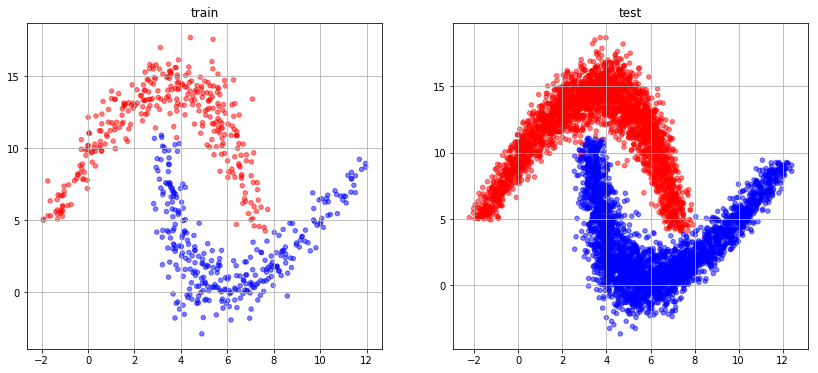

In [7]:
f, axarr = plt.subplots(1,2, sharey=False, sharex=False, figsize=(14,6),)

i=0
axarr[i].set_title('train')
axarr[i].scatter( x=X_train[:,0], 
             y=X_train[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y_train ], 
             s=20,
             alpha=0.5 )
axarr[i].grid()

i+=1
axarr[i].set_title('test')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y_test], 
             s=20,
             alpha=0.5 )
axarr[i].grid()

plt.show()

---

In [ ]:
# набор пороговых классификаторов h(номер признака, порог)
# веса классификаторов

In [ ]:
idx = [0]
bound = [2]

In [ ]:
def h(x,i,b): return (x[:,i]>b).astype(int)

In [13]:
# def err_count(x,y,b): return ((x>b).astype(int)!=y).sum()

In [18]:
# def search_split(X,y,nb=30):

X,y = X_train,y_train

nb = 30 # количество порогов (частей при разбиении отрезка) 

# список порогов для каждого признака
b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] for i in range(X.shape[1]) ])

# изменение количества ошибок для разных признаков и значений порогов 
err_count = np.array([ 
    [ ((X[:,i]>b[i,j]).astype(int)!=y).sum() for i in range(X.shape[1])  ] 
    for j in range(b.shape[1]) 
])

# параметры с минимальным значением ошибок
j,i = np.unravel_index(err_count.argmin(),err_count.shape)


i,b[i,j]
# return i,b[i,j]

(0, 2.8599142451724133)

In [ ]:
# h(X,1,2)

In [11]:
# from sklearn.neighbors import KNeighborsClassifier
# clf = KNeighborsClassifier(n_neighbors=1)
# clf.fit(X_train,y_train) 
# o = clf.predict(X_test)
# (y_test!=o).sum()

In [10]:
# plt.figure(figsize=(7,7))
# plt.scatter( x=X_test[:,0], 
#              y=X_test[:,1], 
#              c=[ 'b' if(j<1) else 'r' for j in o ], 
#              s=20,
#              alpha=0.5 )
# plt.grid()
# plt.show()